In [ ]:
!pip install torch_snippets

import torch_snippets
from torchvision.models import vgg19
from torchvision import transforms as T
from torch.nn import functional as F
import torch.nn as nn
import torch
import torchvision
import numpy as np
import torch.optim as optim
from PIL import Image


class vgg19_modified(nn.Module):
    def __init__(self):
        super().__init__()
        features = list(vgg19(pretrained=True).features)
        self.features = nn.ModuleList(features).eval()

    def forward(self, x, layers=[]):
        order = np.argsort(layers)
        _results, results = [], []
        for ix, model in enumerate(self.features):
            x = model(x)
            if ix in layers: _results.append(x)
        for o in order: results.append(_results[o])
        return results if layers is not [] else x

class GramMatrix(nn.Module):
    def forward(self, input):
        b, c, h, w = input.size()
        feat = input.view(b, c, h * w)
        G = feat @ feat.transpose(1, 2)
        G.div_(h * w)
        return G

class GramMSELoss(nn.Module):
    def forward(self, input, target):
        out = F.mse_loss(GramMatrix()(input), target)
        return (out)


class Neural_style_transfer:

    def __init__(self):

        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

        self.preprocess = T.Compose([
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            T.Lambda(lambda x: x.mul_(255))
        ])
        self.postprocess = T.Compose([
            T.Lambda(lambda x: x.mul_(1. / 255)),
            T.Normalize(mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
                        std=[1 / 0.229, 1 / 0.224, 1 / 0.225]),
        ])
        self.image_size = 512

    def set_images(self, original, style):

        self.style_img = style
        self.original_img = original

    def load_image(self, image_path, transform=None, max_size=None,
                   shape=None):
        """Load an image and convert it to a torch tensor."""
        image = Image.open(image_path).convert("RGB")


        if max_size:
            scale = max_size / max(image.size)
            size = np.array(image.size) * scale
            image = image.resize(size.astype(int), Image.ANTIALIAS)

        if shape:
            image = image.resize(shape, Image.LANCZOS)

        if transform:
            image = transform(image).unsqueeze(0)

        return image.to(self.device)


    def modeling(self):

        vgg = vgg19_modified().to(self.device)

        content_image = self.load_image(self.original_img,
                                   transform=self.preprocess,
                                   max_size=self.image_size)
        style_image = self.load_image(self.style_img, transform=self.preprocess,
                                shape=[content_image.size(2),
                                       content_image.size(3)])


        opt_img = content_image.data.clone()
        opt_img.requires_grad = True
        style_layers = [0, 5, 10, 19, 28]
        content_layers = [21]
        loss_layers = style_layers + content_layers

        loss_fns = [GramMSELoss()] * len(style_layers) + [nn.MSELoss()] * len(
            content_layers)
        loss_fns = [loss_fn.to(self.device) for loss_fn in loss_fns]

        style_weights = [1000 / n ** 2 for n in [64, 128, 256, 512, 512]]
        content_weights = [1]
        weights = style_weights + content_weights

        style_targets = [GramMatrix()(A).detach() for A in
                         vgg(style_image, style_layers)]
        content_targets = [A.detach() for A in
                           vgg(content_image, content_layers)]
        targets = style_targets + content_targets

        max_iters = 500
        optimizer = optim.LBFGS([opt_img])
        log = torch_snippets.Report(max_iters)

        iters = 0
        while iters < max_iters:
            def closure():
                nonlocal iters
                iters += 1
                optimizer.zero_grad()
                out = vgg(opt_img, loss_layers)
                layer_losses = [weights[a] * loss_fns[a](A, targets[a]) for
                                a, A in
                                enumerate(out)]
                loss = sum(layer_losses)
                loss.backward()
                log.record(pos=iters, loss=loss, end='\r')
                return loss

            optimizer.step(closure)



        with torch.no_grad():
            out_img = self.postprocess(opt_img[0]).permute(1, 2, 0)


        tensor = torch.clip(out_img, 0, 1).permute(2, 0, 1)
        to_pil = T.ToPILImage()
        result_image = to_pil(tensor)
        # Save PIL image to file
        result_image.save("image.jpg")
 
        return result_image, log

In [2]:
a = Neural_style_transfer()

# you can add your photos here
a.set_images('man.jpg', 'style11.jpg')

result, log = a.modeling()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EPOCH: 500.000  loss: 194191.281  (61.43s - 0.00s remaining)

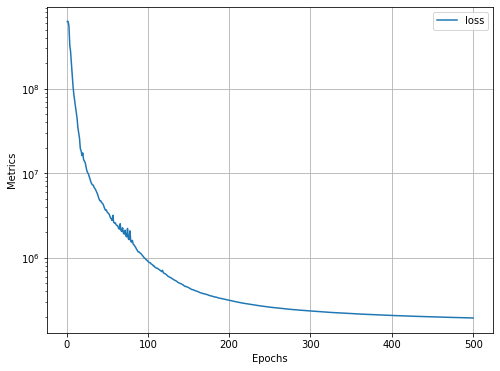

In [3]:
log.plot(log=True)

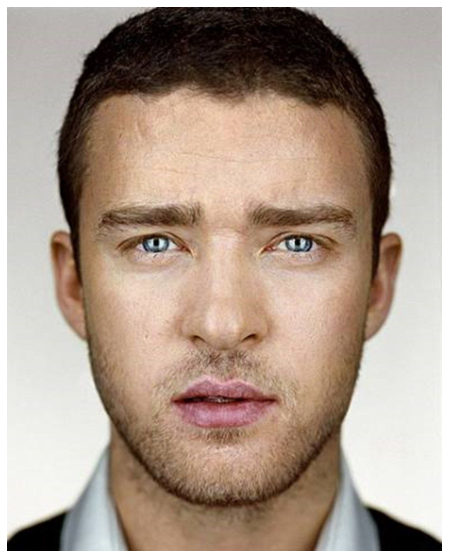

In [4]:
# original picture
torch_snippets.show('man.jpg')

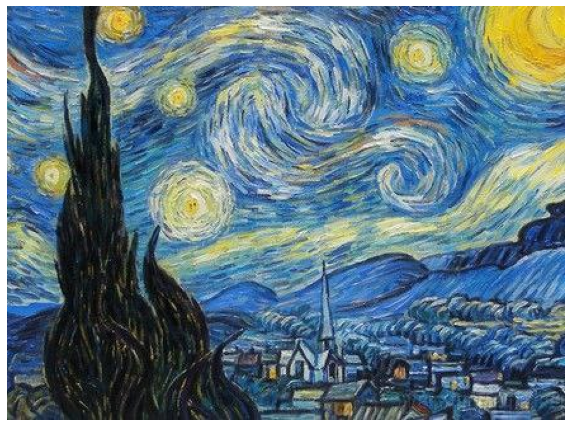

In [6]:
# style picture
torch_snippets.show('style11.jpg')

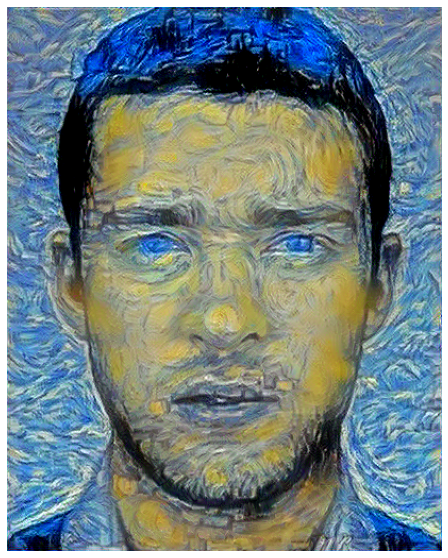

In [7]:
torch_snippets.show(result)